Use the raw data to train and play with the regularization.

In [1]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, data_aug_knn, perform_eval
from modelval.ArbDataGen import arb_w_gen
from modelval.spk_visu import spk_see, raster
from modelval import gp_regressor
from modelval import data_aug_gp
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60


In [3]:
# Generate data for STDP
data1 = data[data['ptl_idx']==1]

# Split into training, testing and validation set
np.random.seed(7)
data1_idx = np.random.permutation(len(data1))
len_test = int(len(data1) * 0.2)
len_vali = int(len(data1) * 0.16)
data_stdp_test = data1.iloc[data1_idx[:len_test]]
y_stdp_test = np.array(data_stdp_test['dw_mean']).reshape(-1,1)
data_stdp_vali = data1.iloc[data1_idx[len_test:len_test+len_vali]]
y_stdp_vali = np.array(data_stdp_vali['dw_mean']).reshape(-1,1)
data_stdp_train = data1.iloc[data1_idx[len_test+len_vali:]]
y_stdp_train = np.array(data_stdp_train['dw_mean']).reshape(-1,1)

[-110, 110, -50, 110]

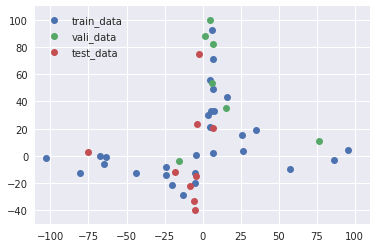

In [4]:
plt.plot(data_stdp_train['dt1'], y_stdp_train, 'o',label='train_data')
plt.plot(data_stdp_vali['dt1'], y_stdp_vali, 'o',label='vali_data')
plt.plot(data_stdp_test['dt1'],y_stdp_test, 'o', label='test_data')
plt.legend(loc='upper left')
plt.axis([-110,110,-50,110])

In [5]:
data_stdp_train.shape, y_stdp_train.shape, data_stdp_vali.shape, y_stdp_vali.shape,data_stdp_test.shape, y_stdp_test.shape

((29, 13), (29, 1), (7, 13), (7, 1), (9, 13), (9, 1))

In [6]:
# Generate data for STDP
data3 = data[data['ptl_idx']==3]

# Split into training, testing and validation set
np.random.seed(9)
data3_idx = np.random.permutation(len(data3))
len_test = int(len(data3) * 0.2)
len_vali = int(len(data3) * 0.16)
data_quad_test = data3.iloc[data3_idx[:len_test]]
y_quad_test = np.array(data_quad_test['dw_mean']).reshape(-1,1)
data_quad_vali = data3.iloc[data3_idx[len_test:len_test+len_vali]]
y_quad_vali = np.array(data_quad_vali['dw_mean']).reshape(-1,1)
data_quad_train = data3.iloc[data3_idx[len_test+len_vali:]]
y_quad_train = np.array(data_quad_train['dw_mean']).reshape(-1,1)

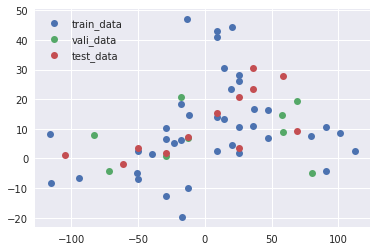

In [7]:
plt.plot(data_quad_train['dt2'], y_quad_train, 'o',label='train_data')
plt.plot(data_quad_vali['dt2'], y_quad_vali, 'o',label='vali_data')
plt.plot(data_quad_test['dt2'],y_quad_test, 'o', label='test_data')
plt.legend(loc='upper left')


In [8]:
data_quad_train.shape, y_quad_train.shape, data_quad_vali.shape, y_quad_vali.shape, data_quad_test.shape, y_quad_test.shape

((39, 13), (39, 1), (9, 13), (9, 1), (12, 13), (12, 1))

In [9]:
# Generate data for Triplet
dt = np.array([-10, -5, 0, 5, 10]).reshape(-1,1)
data_trip, y_trip, data_trip_test, y_trip_test = data_aug_gp.triplet_dw_gen(n_samples=1)

# Split the triplet data into training and validation
np.random.seed(10)
idx = np.random.permutation(len(data_trip))
data_trip_train = data_trip.iloc[idx[:int(len(data_trip)*0.8)]]
y_trip_train = y_trip[idx[:int(len(data_trip)*0.8)]]
data_trip_vali = data_trip.iloc[idx[int(len(data_trip)*0.8):]]
y_trip_vali = y_trip[idx[int(len(data_trip)*0.8):]]

In [10]:
data_trip_train.shape, data_trip_vali.shape, data_trip_test.shape

((6, 13), (2, 13), (11, 13))

In [11]:
# Combine data from stdp and quadruplet
data_gen_train = pd.concat([data_stdp_train, data_trip_train, data_quad_train], axis=0)
y_train = np.concatenate([y_stdp_train, y_trip_train, y_quad_train])
data_gen_vali = pd.concat([data_stdp_vali, data_trip_vali, data_quad_vali], axis=0)
y_vali = np.concatenate([y_stdp_vali, y_trip_vali, y_quad_vali])
data_gen_test = pd.concat([data_stdp_test, data_trip_test, data_quad_test], axis=0)
y_test = np.concatenate([y_stdp_test, y_trip_test, y_quad_test])

In [12]:
data_gen_train.shape, y_train.shape, data_gen_vali.shape, y_vali.shape

((74, 13), (74, 1), (18, 13), (18, 1))

In [13]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]

# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

len_kernel = 101
len_trip = 151
ker_test = KernelGen(len_kernel=len_kernel, len_trip=len_trip)
ker_test.trip_model_ker(para, data_name='Hippocampus')

In [14]:
# Generat the spike trains and targets for STDP
data_hippo = data[data['ptl_idx']<5]
ptl_list = [1,2,3,4]
spk_len = int(data_hippo['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 1
aug_times = [1,1,1,1]
spk_pairs_train, targets_train = arb_w_gen(df=data_gen_train, ptl_list=ptl_list, targets=y_train, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)
spk_pairs_vali, targets_vali = arb_w_gen(df=data_gen_vali, ptl_list=ptl_list, targets=y_vali, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [15]:
spk_pairs_train.shape

(74, 30002, 2)

In [16]:
# Create the network
ground_truth_init = 0
reg_scale=(10,50,500,3000)
init_seed=(4,5,6,7,8)

toy_data_net = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, reg_scale=reg_scale, n_input=spk_pairs_train.shape[1])

In [17]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/Trip_ptl1_4_real_raw_data0'
toy_net_trainer = trainer.Trainer(toy_data_net.mse, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [18]:
train_data = dataset.Dataset(spk_pairs_train, targets_train)
vali_data = dataset.Dataset(spk_pairs_vali, targets_vali)

[-0.22614121 -0.27994752  0.95375919] [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


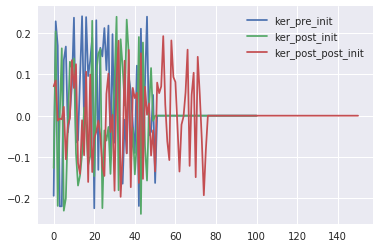

In [19]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(w_pre,  label='ker_pre_init')
plt.plot(w_post,  label='ker_post_init')
plt.plot(w_post_post,  label='ker_post_post_init')

plt.legend()
print(fc_w, bias)

In [22]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for i in range(iterations):
    toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
    learning_rate = learning_rate/3

Global Step 5050 and Step 0012: validation mse=680.76013
Global Step 5100 and Step 0062: validation mse=680.57153
Updated min validation loss!Saving model...
Global Step 5150 and Step 0112: validation mse=680.49084
Updated min validation loss!Saving model...
Global Step 5200 and Step 0162: validation mse=680.44690
Updated min validation loss!Saving model...
Global Step 5250 and Step 0212: validation mse=680.28625
Updated min validation loss!Saving model...
Global Step 5300 and Step 0262: validation mse=680.43152
Global Step 5350 and Step 0312: validation mse=680.45923
Global Step 5400 and Step 0362: validation mse=680.13092
Updated min validation loss!Saving model...
Global Step 5450 and Step 0412: validation mse=680.63049
Global Step 5500 and Step 0462: validation mse=680.76855
Global Step 5550 and Step 0512: validation mse=680.90332
Global Step 5600 and Step 0562: validation mse=681.07037
Global Step 5650 and Step 0612: validation mse=681.34143
Global Step 5700 and Step 0662: validat

[array([-3.47749662, -4.07789803,  6.22867346], dtype=float32), array([[ 3.12642169],
       [-2.40600181],
       [-2.78014851],
       [ 3.61282706]], dtype=float32)]


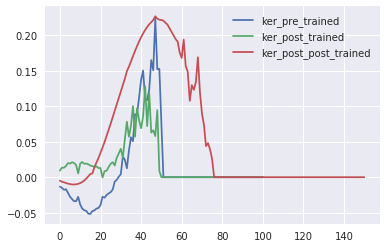

In [23]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(-1*w_pre, label='ker_pre_trained')
plt.plot(-1*w_post, label='ker_post_trained')
plt.plot(-1*w_post_post, label='ker_post_post_trained')
plt.legend()
print([fc_w, bias])

In [29]:
np.linalg.norm(w_pre, ord=2)

0.54981321

In [ ]:
def kernel_hp2(w, len=11):
    """
    Use the hamming filter to detect the frequency range that you want to eliminate
    :param w:
    :return:
    """
    window = signal.hamming(len)
    hp_ker2 = tf.constant(window / np.sum(window), shape=(len, 1), dtype=tf.float32)
    w_out = w - tf.nn.conv1d(tf.expand_dims(input=w, axis=0), tf.expand_dims(hp_ker2, axis=2),
                         stride=1, padding='SAME')
    return w_out

In [ ]:
from scipy import signal

with tf.Graph().as_default():
    window = signal.hamming(11)
    w = tf.constant(w_post_post, dtype=tf.float32)
    
    w_hp = kernel_hp2(w, len=11)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        window_inst = sess.run(w_hp)
    
plt.plot(np.squeeze(window_inst))
plt.plot(w_post_post)

In [ ]:
# # Test effect of smoothed kernel
# w_pre_sm = w_pre
# w_post_sm = w_post 
# w_post_post_sm = w_post_post
# w_pre_sm[:50] = dw_gen.smooth(w_pre[:50], width=2)
# w_post_sm[:48] = dw_gen.smooth(w_post[:48], width=2)
# w_post_post_sm[:49] = dw_gen.smooth(w_post_post[:49], width=3)

# plt.plot(-1 * w_pre_sm)
# plt.plot(-1 * w_post_sm)
# plt.plot(-1*w_post_post_sm)

# ker_test.kernel_pre = w_pre_sm
# ker_test.kernel_post = w_post_sm
# ker_test.kernel_post_post= w_post_post_sm
# ker_test.kernel_scale = fc_w
# ker_test.bias = bias

Compare the target and prediction

In [ ]:
# Updated the kernel as trained kernel
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
ker_test.kernel_post_post= w_post_post
ker_test.kernel_scale = fc_w
ker_test.bias = bias

In [ ]:
# Generate training predictions
spk_len = int(data['train_len'].max() * 1000 / ker_test.reso_kernel)
_, predictions_train = arb_w_gen(spk_pairs=spk_pairs_train, spk_len=spk_len, kernel=ker_test, net_type='triplet')

ptl_len = np.array([29,3,39,3])
rep_time = np.array([1,1,1,1])
ptl_len, targets_out, predictions_out = data_aug_knn.target_pred_gen(targets_train, predictions_train, ptl_len, rep_time)

# Calculate the total sum of squares
R2 = 1 - np.sum(np.square(predictions_train-targets_train))/(np.square(np.std(targets_train))*(len(targets_train)-1))

plt.plot(np.linspace(-30,50,80), np.linspace(-30,50,80),'k--')
ptl_type = ['stdp', 'trip1', 'quad','trip2']
for i in range(len(ptl_len)):
    plt.plot(targets_out[i], predictions_out[i],'o', label=ptl_type[i])

plt.title('Training data (R2=%0.2f)'%(R2))
plt.legend()

In [ ]:
# Generate validation predictions
spk_len = int(data['train_len'].max() * 1000 / ker_test.reso_kernel)
_, predictions_vali = arb_w_gen(spk_pairs=spk_pairs_vali, spk_len=spk_len, kernel=ker_test, net_type='triplet')

ptl_len = np.array([7,1,9,1])
rep_time = np.array([1,1,1,1])
ptl_len, targets_out, predictions_out = data_aug_knn.target_pred_gen(targets_vali, predictions_vali, ptl_len, rep_time)

# Calculate the total sum of squares
R2 = 1 - np.sum(np.square(predictions_vali-targets_vali))/(np.square(np.std(targets_vali))*(len(targets_vali)-1))
corr = np.sqrt(R2)

plt.plot(np.linspace(-30,50,80), np.linspace(-30,50,80),'k--')
ptl_type = ['stdp', 'trip1', 'quad','trip2']
for i in range(len(ptl_len)):
    plt.plot(targets_out[i], predictions_out[i],'o', label=ptl_type[i])

plt.title('Validation data (R2=%0.2f)'%(R2))
plt.legend()

In [ ]:
# Generat the spike trains and targets for STDP
data3 = data[data['ptl_idx']==3]
ptl_list = [1,2,3,4]
spk_len = int(data3['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 0
aug_times = [1,1,1,1]
spk_pairs_test, targets_test = arb_w_gen(df=data_gen_test, ptl_list=ptl_list, targets=y_test, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [ ]:
# Generate test predictions
spk_len = int(data['train_len'].max() * 1000 / ker_test.reso_kernel)
_, predictions_test = arb_w_gen(spk_pairs=spk_pairs_test, spk_len=spk_len, kernel=ker_test, net_type='triplet')

ptl_len = np.array([12,7,18,4])
rep_time = np.array([1,1,1,1])
ptl_len, targets_out, predictions_out = data_aug_knn.target_pred_gen(targets_test, predictions_test, ptl_len, rep_time)

# Calculate the total sum of squares
R2 = 1 - np.sum(np.square(predictions_test-targets_test))/(np.square(np.std(targets_test))*(len(targets_test)-1))
corr = np.sqrt(R2)

plt.plot(np.linspace(-30,50,80), np.linspace(-30,50,80),'k--')
ptl_type = ['stdp', 'trip1', 'quad','trip2']
for i in range(len(ptl_len)):
    plt.plot(targets_out[i], predictions_out[i],'o', label=ptl_type[i])

plt.title('Testing data (R2=%0.2f)'%(R2))
plt.legend()